Aims of this dataset:<br>
Combine most useful feats of chem and MACCS keys<br>
validate importance of source feature

In [1]:
# temporary working here to deal with double values and insert it later as new section before section joining

In [1]:
import numpy as np
import pandas as pd
import _pickle as pkl

#### 2. Joining

In [136]:
with open('./intermediate-pickles-scoring2/dataWithSource.pkl', 'rb') as inp:
    data1 = pkl.load(inp)
with open('./intermediate-pickles-scoring2/data2.pkl', 'rb') as inp:
    data2 = pkl.load(inp)

In [137]:
data2 = data2[data2["HSA"]<84.4]

In [138]:
# double Data
dataReversed1 = data1
dataReversed2 = data2

dataReversed1 = dataReversed1.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})
dataReversed2 = dataReversed2.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})

dataDouble1 = data1.append(dataReversed1)
dataDouble2 = data2.append(dataReversed2)

dataDouble1.reset_index(inplace=True,drop=True)
dataDouble2.reset_index(inplace=True,drop=True)

print(len(dataDouble1)," records in first frame")
print(len(dataDouble2)," records in second frame")
dataDouble1.head(2)

492814  records in first frame
811376  records in second frame


,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,source
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797,ONEIL
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325,ONEIL


Drug Feature import part

In [139]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

drug_feats = pd.read_csv("./output/all_drugs_with_smiles.csv")
drug_feats["mol-object"]=[Chem.MolFromSmiles(mol) for mol in drug_feats["smilesString"]]

maccsFrame = pd.DataFrame(drug_feats["drugName"])
maccsFrame["MACCSk"] = [np.array(Chem.MACCSkeys.GenMACCSKeys(mol)) for mol in drug_feats["mol-object"]]

joinMaccs = pd.DataFrame([])
for i in range(len(maccsFrame)):
    joinMaccs = joinMaccs.append(pd.Series(maccsFrame.iloc[i,1]),ignore_index=True)
    
drugMACCS = maccsFrame.join(joinMaccs,how="left").drop(columns="MACCSk")

In [140]:
drugMACCS.head(2)

,drugName,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,Bendamustine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,Lonidamine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [141]:
drug_feats = drugMACCS
drug_feats.set_index("drugName",inplace=True)
drug_feats.index = drug_feats.index.str.lower()

d1_drugs = drug_feats.add_prefix("D1 ")
d2_drugs = drug_feats.add_prefix("D2 ")

dataDouble_drug1_feats1 = dataDouble1.join(d1_drugs,on="Drug1",how="left")
dataDouble_drug1_feats2 = dataDouble2.join(d1_drugs,on="Drug1",how="left")

dataDouble_all_feats1 = dataDouble_drug1_feats1.join(d2_drugs,on="Drug2",how="left")
dataDouble_all_feats2 = dataDouble_drug1_feats2.join(d2_drugs,on="Drug2",how="left")

Cell Line Info from Ammar

In [142]:
# Ammars output files
cellLine_info = pd.read_csv('output/cell_lines_enriched.csv', sep=',', dtype='string')
drug_info = pd.read_csv('output/all_drugs_with_smiles.csv', sep=',', dtype='string')

cat_ohe = pd.get_dummies(cellLine_info.category, prefix='cat')
cellLine_info_full = pd.concat([cellLine_info,cat_ohe], axis=1)

gender_ohe = pd.get_dummies(cellLine_info.gender, prefix='gender')

cellLine_info_full['age'] = cellLine_info_full['age'].str.replace('Y','').replace('Age unspecified','0')
cellLine_info_full['age'] = cellLine_info_full['age'].astype('int')

cellLine_info_full = cellLine_info_full.drop('cosmicId', 1)
cellLine_info_full = cellLine_info_full.drop('category', 1)
cellLine_info_full = cellLine_info_full.drop('gender', 1)

In [143]:
data1 = dataDouble_all_feats1.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left").dropna() #expensive losses
data2 = dataDouble_all_feats2.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left").dropna()

In [29]:
# I don't think I need all these pickles stored
# with open('./intermediate-pickles-scoring2/finalFrame1.pkl', 'wb') as outp:
#     pkl.dump(finalFrame1, outp)
# with open('./intermediate-pickles-scoring2/finalFrame2.pkl', 'wb') as outp:
#     pkl.dump(finalFrame2, outp)

#### 3. Combination ID?

In [144]:
data1.reset_index(inplace=True,drop=True)
data2.reset_index(inplace=True,drop=True)
print("Data1 has records ",len(data1))
print("Data2 has records ",len(data2))
data1.head(2)

Data1 has records  468730
Data2 has records  614608


,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,...,D2 162,D2 163,D2 164,D2 165,D2 166,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0


#### 4. Making Predictions

In [11]:
Y1 = data1.iloc[:,9]
X1 = data1.iloc[:,11:]
X1 = X1.iloc[:,1:]

Y2 = data2.iloc[:,9]
X2 = data2.iloc[:,10:]
X2 = X2.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train1,x_test1,Y_train1,y_test1 = train_test_split(X1,Y1,test_size=0.3,stratify=Y1) #consider stratifying on combination
X_train2,x_test2,Y_train2,y_test2 = train_test_split(X2,Y2,test_size=0.3,stratify=Y2)

In [27]:
from sklearn.ensemble import RandomForestRegressor 

regressor1 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor1.fit(X_train1,Y_train1)

predTrain1=regressor1.predict(X_train1)
predTest1=regressor1.predict(x_test1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [28]:
regressor2 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor2.fit(X_train2,Y_train2)

predTrain2=regressor2.predict(X_train2)
predTest2=regressor2.predict(x_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [155]:
data1.head(2)

,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,...,D2 162,D2 163,D2 164,D2 165,D2 166,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325,...,1.0,1.0,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0


In [157]:
YB = data1.iloc[:,8]
XB = data1.iloc[:,9:]

from sklearn.model_selection import train_test_split

sourceDummies = pd.get_dummies(XB.source,prefix="Source")
XB[["Source_ALMANAC","Souce_ONEIL"]]=sourceDummies

XB.drop(["source"],axis=1,inplace=True)

X_trainB,x_testB,Y_trainB,y_testB = train_test_split(XB,YB,test_size=0.3,stratify=YB) #consider stratifying on combination

XB.head(2)

,index,D1 0,D1 1,D1 2,D1 3,D1 4,D1 5,D1 6,D1 7,D1 8,...,D2 164,D2 165,D2 166,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,Source_ALMANAC,Souce_ONEIL
0,62797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0,0,1
1,36325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,43.0,1.0,0.0,0.0,0.0,0,1


In [158]:
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_trainB.pkl', 'wb') as outp:
    pkl.dump(X_trainB, outp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_testB.pkl', 'wb') as outp:
    pkl.dump(x_testB, outp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_trainB.pkl', 'wb') as outp:
    pkl.dump(Y_trainB, outp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_testB.pkl', 'wb') as outp:
    pkl.dump(y_testB, outp)

In [38]:

regressorB = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressorB.fit(X_trainB.iloc[:,1:],Y_trainB)

predTrainB=regressorB.predict(X_trainB)
predTestB=regressorB.predict(x_testB)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [15]:
from sklearn.dummy import DummyRegressor

# Data1
dummyRegressor1 = DummyRegressor()
dummyRegressor1.fit(X_train1,Y_train1)

predTrainDumm1=dummyRegressor1.predict(X_train1)
predTestDumm1=dummyRegressor1.predict(x_test1)

#Data2
dummyRegressor2 = DummyRegressor()
dummyRegressor2.fit(X_train2,Y_train2)

predTrainDumm2=dummyRegressor2.predict(X_train2)
predTestDumm2=dummyRegressor2.predict(x_test2)

#Data B
dummyRegressorB = DummyRegressor()
dummyRegressorB.fit(X_trainB,Y_trainB)

predTrainDummB=dummyRegressorB.predict(X_trainB)
predTestDummB=dummyRegressorB.predict(x_testB)

#### Scoring (Mean Absolute/Squared Error)

In [34]:
print("## The performances are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.abs(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.abs(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm2-y_test2)))

## The performances are:

Small Dataset:
On Training Data:  3.8735736195579915
On Testing  Data:  3.8925051812921905
Dummy Training  :  3.9970085632976433
Dummy Testing   :  4.020192456616437

Big Dataset:
On Training Data:  4.0489834412588905
On Testing  Data:  4.0597795306040805
Dummy Training  :  4.159212070389421
Dummy Testing   :  4.1722321269988685


In [35]:
print("## The performances are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.square(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.square(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm2-y_test2)))

## The performances are:

Small Dataset:
On Training Data:  33.07288422243679
On Testing  Data:  34.16080958570555
Dummy Training  :  35.52366874305311
Dummy Testing   :  36.69735845712762

Big Dataset:
On Training Data:  35.524583660779705
On Testing  Data:  36.04437226826528
Dummy Training  :  37.92288193531876
Dummy Testing   :  38.46852403117986


In [40]:
#for source feature on small Dataset
print("## The performances for Big Tree are:")
print("\nMAE:")
print("On Training Data: ",np.mean(np.abs(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.abs(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDummB-y_testB)))
print("\nMSE:")
print("On Training Data: ",np.mean(np.square(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.square(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.square(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.square(predTestDummB-y_testB)))

## The performances for Big Tree are:

MAE:
On Training Data:  3.770320208092335
On Testing  Data:  3.79095900809306
Dummy Training  :  3.999038972029706
Dummy Testing   :  4.01597279816774

MSE:
On Training Data:  31.782656239156356
On Testing  Data:  32.73795414235455
Dummy Training  :  35.59075884711726
Dummy Testing   :  36.54072557781606


In [44]:
featsB = pd.DataFrame([np.array(x_testB.columns),regressorB.feature_importances_]).transpose()
featImportance = featsB.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance.rename(columns={0:"Feat B",1:"Relevance B"},inplace=True)

feats1 = pd.DataFrame([np.array(x_test1.columns),regressor1.feature_importances_]).transpose()
featImportance[["Feat 1","Relevance 1"]] = feats1.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)

feats2 = pd.DataFrame([np.array(x_test2.columns),regressor2.feature_importances_]).transpose()
featImportance[["Feat 2","Relevance 2"]] = feats2.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance

#  145: ('*1~*~*~*~*~*~1', 1),  # 6M ring > 1
# absolutely no idea why this is so disproportionately important
# Even After source: It's not a proxy (actually evenly distributed)
# probably all other are completely irrelavant and this is the only one with at least something

,Feat B,Relevance B,Feat 1,Relevance 1,Feat 2,Relevance 2
0,Souce_ONEIL,0.415335,D2 145,0.279642,D2 145,0.31196
1,Source_ALMANAC,0.177741,D1 145,0.265141,D1 145,0.296716
2,D2 145,0.111691,D1 150,0.075136,D1 97,0.041471
3,D1 145,0.088233,D2 150,0.071736,D1 154,0.041178
4,D1 79,0.031438,D2 138,0.067723,D2 97,0.039991
5,D1 144,0.02882,D2 50,0.026705,D2 154,0.038564
6,D2 144,0.024271,D1 77,0.019802,D2 150,0.029796
7,D2 79,0.02111,D1 50,0.019659,D1 150,0.028593
8,D2 89,0.019749,D1 153,0.015196,D1 141,0.027942
9,D1 89,0.010247,D1 138,0.015154,D2 141,0.023138


#### Parameter Tuning: First Attempt

First I'll try different sizes of max_samples, max_depth, min_samples_split and number of trees

In [ ]:
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_trainB.pkl', 'rb') as inp:
    X_trainB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_testB.pkl', 'rb') as inp:
    x_testB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_trainB.pkl', 'rb') as inp:
    Y_trainB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_testB.pkl', 'rb') as inp:
    y_testB = pkl.load(inp)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

scoresTrain = []
scoresTest = []

max_samplesF = [0.001,0.01,0.3,0.9999]
max_depthF = [18,10,6,2]
min_samples_splitF = [2,10,50,250,1250]
no_trees = [5,50,200]

print("starting now")
for k in max_samplesF:
    localTrain3= []
    localTest3 = []
    for j in max_depthF:
        localTrain2= []
        localTest2 = []
        for i in min_samples_splitF:
            localTrain1= []
            localTest1 = []
            for l in no_trees:
                regressorN = RandomForestRegressor(max_depth=j, max_samples=k,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=l, verbose=True)
                regressorN.fit(X_trainB.iloc[:,1:],Y_trainB)
        
                localTrain1.append(np.mean(np.abs(regressorN.predict(x_trainB.iloc[:,1:])-y_trainB))) #do also train
                localTest1.append(np.mean(np.abs(regressorN.predict(X_testB.iloc[:,1:])-Y_testB))) 
                del regressorN
            localTrain2.append(localTrain1)
            localTest2.append(localTest1)
        localTrain3.append(localTrain2)
        localTest3.append(localTest2)
        
    scoresTrain.append(localTrain3)
    scoresTest.append(localTest3)

<b>Performance Illustrations:</b><br>
At first I will make two plots showing the overall performance.<br>
Since we have 4 features varied, it is only easy to read the overall change of 2 of them, therefore I will make plots, illustrating all combinations of 2 features<br><br>
-The "outest" feature is how the chart overall develops<br>
-The "inner" feature  will be how each of the 3-5 major partitions develop

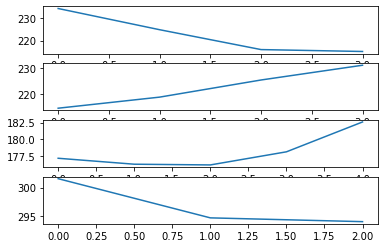

In [37]:
#avg performances of single indicators 
arrMaxSamples = [0,0,0,0]
arrMaxDepth = [0,0,0,0]
arrMinSampleSplit = [0,0,0,0,0]
arrNoTrees = [0,0,0]

for i in range(4):
    for j in range(4):
        for k in range(5):
            for l in range(3):
                arrMaxSamples[i] += pred[i][j][k][l]
                arrMaxDepth[j] += pred[i][j][k][l]
                arrMinSampleSplit[k] += pred[i][j][k][l]
                arrNoTrees[l] +=  pred[i][j][k][l]

fig,ax=plt.subplots(4)
ax[0].plot(arrMaxSamples)
ax[1].plot(arrMaxDepth)
ax[2].plot(arrMinSampleSplit)
ax[3].plot(arrNoTrees)

<b>From here it looks like</b><br>
-more trees are better, but that quickly levels off (4)<br>
-keeping all samples is better, bootstrapping is not worth it (1)<br>
-increasing the maxDepth is bad<br>
-ideal number of min samples split, is around 50<br><br>
<b> however that does not account for interactions between the features</b><br>
Therefore I create plots of showing different combinations of features

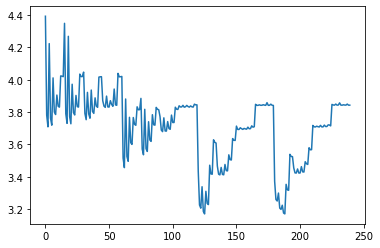

In [70]:
plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),0,0),0,0).flatten())

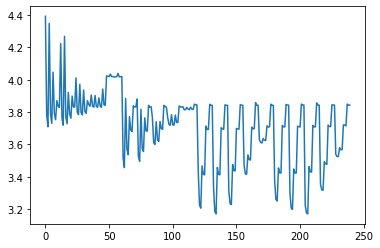

In [87]:
plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),0,0),2,1).flatten())

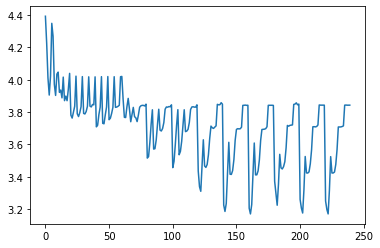

In [88]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),0,0),3,1).flatten())

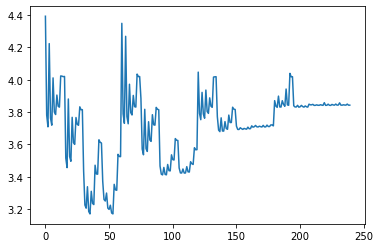

In [86]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),1,0),0,0).flatten())

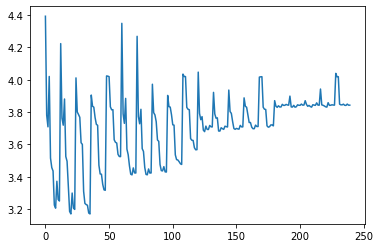

In [85]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),1,0),2,1).flatten())

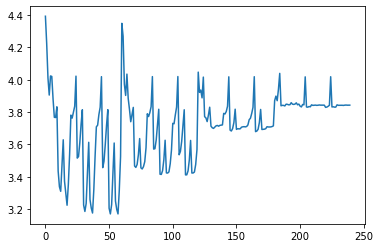

In [84]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),1,0),3,1).flatten())

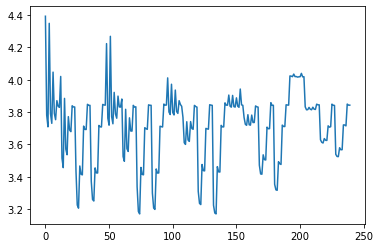

In [83]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),2,0),0,0).flatten())

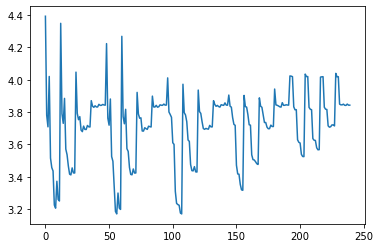

In [82]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),2,0),2,1).flatten())

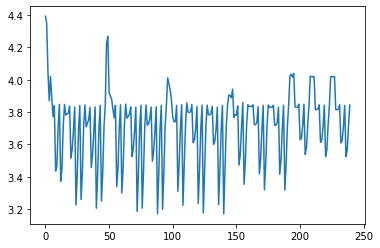

In [81]:

plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),2,0),3,1).flatten())

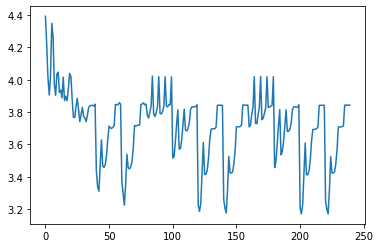

In [80]:
plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),3,0),0,0).flatten())

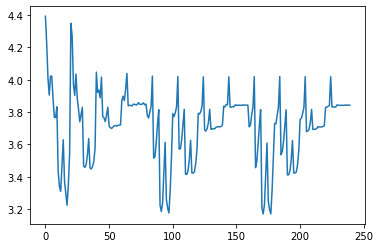

In [79]:
plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),3,0),2,1).flatten())

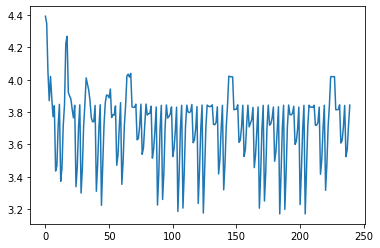

In [78]:
plt.plot(np.moveaxis(np.moveaxis(np.array(scoresTrain),3,0),3,1).flatten())

<B>Actual Findings:</B><br>
-Sampling the number of records each tree is trained on, makes the performance worse - no danger of overfitting. Just don't.<br>
-more max_depth is better so far - no overfitting here<br>
-min_samples_split best performance at around 50 - but stabilises, so smaller better<br>
-more trees are better, but that that much

#### Parameter Tuning 2: Refining Selection of Parameters

In [ ]:
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_trainB.pkl', 'rb') as inp:
    X_trainB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/X_testB.pkl', 'rb') as inp:
    x_testB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_trainB.pkl', 'rb') as inp:
    Y_trainB = pkl.load(inp)
with open('./intermediate-pickles-scoring2/parameterTuningScoring3/Y_testB.pkl', 'rb') as inp:
    y_testB = pkl.load(inp)

In [ ]:
#TEST AND TRAIN SWITCHED UP
from sklearn.ensemble import RandomForestRegressor 

scoresTrain = []
scoresTest = []

max_depthF = [150,80,40,20,10]
min_samples_splitF = [2,4,8,16,32,64]
no_trees = [2,16,128,1024]

print("starting now")
for k in range(1):#placeholder
    localTrain3= []
    localTest3 = []
    for j in max_depthF:
        localTrain2= []
        localTest2 = []
        for i in min_samples_splitF:
            localTrain1= []
            localTest1 = []
            for l in no_trees:
                regressorN = RandomForestRegressor(max_depth=j,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=l, verbose=True)
                regressorN.fit(X_trainB.iloc[:,1:],Y_trainB)
        
                localTest1.append(np.mean(np.abs(regressorN.predict(x_testB.iloc[:,1:])-y_testB))) #do also train
                localTrain1.append(np.mean(np.abs(regressorN.predict(X_trainB.iloc[:,1:])-Y_trainB))) 
                del regressorN
            localTrain2.append(localTrain1)
            localTest2.append(localTest1)
        localTrain3.append(localTrain2)
        localTest3.append(localTest2)
        
    scoresTrain.append(localTrain3)
    scoresTest.append(localTest3)

In [ ]:
predTrain = np.array(scoresTest[0])
predTest = np.array(scoresTrain[0])

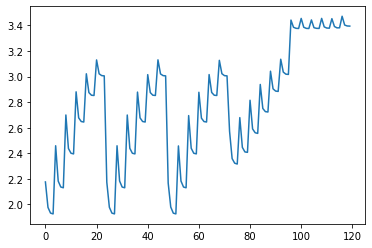

In [43]:
plt.plot(predTest.flatten())

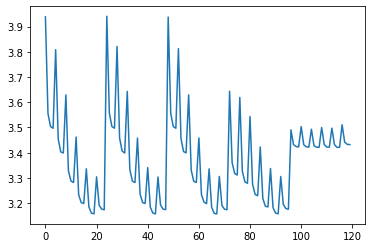

In [42]:
plt.plot(predTrain.flatten())

<b>Findings:</b><br>
1. As long as the max depth is at least like 40, increases only yield minor gains
2. Decreasing the minimum samples for required for splitting, causes overfitting: Big performance gains on the training data, but losses on the testdata. An Effect that bootstrapping in the previous tests likely has mitigated. Best performance around 32
3. Number of trees strongly increases performance when going from a small number to a medium one, but quickly levels off<br><br>
<b>Thus, considering computational effort, the proposed configuration is now 10-60 trees, min samples split ~32 and maxDepth ~40

#### Parameter Tuning 3: Final Selection of Params

In [ ]:
#TEST AND TRAIN SWITCHED UP
from sklearn.ensemble import RandomForestRegressor 

scoresTrain = []
scoresTest = []

max_depthF = [90,60,40,25] #add 0/-1 for no capping
min_samples_splitF = [10,25,35,45,60]
no_trees = [10,35,60]

print("starting now")
for k in range(1):#placeholder
    localTrain3= []
    localTest3 = []
    for j in max_depthF:
        localTrain2= []
        localTest2 = []
        for i in min_samples_splitF:
            localTrain1= []
            localTest1 = []
            for l in no_trees:
                regressorN = RandomForestRegressor(max_depth=j,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=l, verbose=True)
                regressorN.fit(X_trainB.iloc[:,1:],Y_trainB)
        
                localTest1.append(np.mean(np.abs(regressorN.predict(x_testB.iloc[:,1:])-y_testB))) #do also train
                localTrain1.append(np.mean(np.abs(regressorN.predict(X_trainB.iloc[:,1:])-Y_trainB))) 
                del regressorN
            localTrain2.append(localTrain1)
            localTest2.append(localTest1)
        localTrain3.append(localTrain2)
        localTest3.append(localTest2)
    scoresTrain.append(localTrain3)
    scoresTest.append(localTest3)

In [ ]:
pTrain = np.array(scoresTrain[0])
pTest = np.array(scoresTest[0])

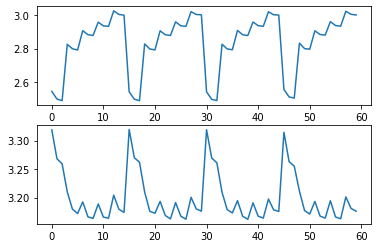

In [57]:
fig,ax = plt.subplots(2)
fig.show()
ax[0].plot(pTrain.flatten())
ax[1].plot(pTest.flatten())

<b>Conclusion:</b><br>
1. Max Depth has its error minima at ~40
2. Min Samples Split at ~40 too and notably overfits at 10
3. 35 trees is still notably better than 10, but performance increases quickly level off<br>

Note: I have not played around with the max number of features to use yet

In [96]:
regressorB = RandomForestRegressor(max_depth=40,min_samples_split = 40,
                                   bootstrap=True, n_jobs=-1,n_estimators=35, verbose=True)
regressorB.fit(X_trainB.iloc[:,1:],Y_trainB)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:  1.1min remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.1min finished


RandomForestRegressor(max_depth=40, min_samples_split=40, n_estimators=35,
                      n_jobs=-1, verbose=True)

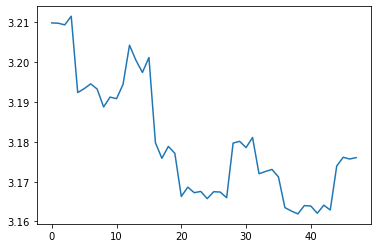

In [94]:
# Illustrating the remaining performance fluctuations in 1 Graph:

#main axis: No Trees, second: min samples split
final = np.moveaxis(np.moveaxis(pTest,0,2)[1:],1,0)

plt.plot(final.flatten())

#### Feature Relevance in Tuned Model

In [164]:
regressorB = RandomForestRegressor(max_depth=40,min_samples_split = 40,
                                   bootstrap=True, n_jobs=-1,n_estimators=35, verbose=True)
regressorB.fit(X_trainB.iloc[:,1:],Y_trainB)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:   50.8s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   51.5s finished


RandomForestRegressor(max_depth=40, min_samples_split=40, n_estimators=35,
                      n_jobs=-1, verbose=True)

In [165]:
featsB = pd.DataFrame([np.array(x_testB.iloc[:,1:].columns),regressorB.feature_importances_]).transpose()
featImportance = featsB.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance.rename(columns={0:"Feat B",1:"Relevance B"},inplace=True)
featImportance

#  145: ('*1~*~*~*~*~*~1', 1),  # 6M ring > 1
# absolutely no idea why this is so disproportionately important
# Even After source: It's not a proxy (actually evenly distributed)
# probably all other are completely irrelavant and this is the only one with at least something

,Feat B,Relevance B
0,age,0.121256
1,Souce_ONEIL,0.069558
2,Source_ALMANAC,0.052294
3,D2 145,0.023028
4,D1 145,0.017826
5,D2 79,0.017032
6,D1 79,0.016536
7,D2 129,0.009675
8,D1 129,0.009551
9,D2 54,0.009367


In [168]:
print(np.mean(np.abs(regressorB.predict(x_testB.iloc[:,1:])-y_testB)))
print(np.mean(np.abs(regressorB.predict(X_trainB.iloc[:,1:])-Y_trainB))) 

[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.2s finished


3.1798777596837726


[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.3s remaining:    5.0s


2.8942472979645357


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.7s finished


In [181]:
pred = regressorB.predict(x_testB.iloc[:,1:])
pred2 = regressorB.predict(X_trainB.iloc[:,1:])

obs = pd.DataFrame({"combination_idx":x_testB.iloc[:,0],"y_test":y_testB,"pred":pred})
obs2 = pd.DataFrame({"combination_idx":X_trainB.iloc[:,0],"y_test":Y_trainB,"pred":pred2})

obs.head()

[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.1s remaining:    2.1s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.3s finished
[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.3s remaining:    5.4s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.5s finished


,combination_idx,y_test,pred
192154,52386,-1.40,-0.922643
322350,47799,-7.96,-3.824749
63776,41215,-5.86,-4.551162
415032,58817,-0.66,1.441974
136680,66020,-1.20,-1.061491


In [183]:
from scoring import primaryMetric
print("Theoretical Maximum through experimental reproducibility: ~0.42")
print("Performance on Training Data: ",primaryMetric(obs2))
print("Performance on Test Data: ",primaryMetric(obs))

Challenge Winner Performance: ~0.4
Performance on Training Data:  0.45476103847449895
Performance on Test Data:  0.07389756770603086


In [192]:
np.mean(np.abs(obs2.iloc[:,2]-obs2.iloc[:,1]))

2.8942472979645357

In [187]:
print(primaryMetric(pd.DataFrame({"combination_idx":X_trainB.iloc[:,0],"y_test":Y_trainB,"pred":Y_trainB})))
print(primaryMetric(pd.DataFrame({"combination_idx":x_testB.iloc[:,0],"y_test":y_testB,"pred":y_testB})))

0.9981146694231473
0.9992184685762865


Next steps:

Cell Line Profiles

other params: max feats